![KU Leuven](img/logo.png)
# Biometrics System Concepts
## Assignment 2: Fingerprint and Iris based Identification

**Name:** Joe Pesci |
**Student Nr:** KD6-3.7 |
**Date:** February 10, 1942
---

Implement and test a keypoint-based fingerprint and iris recognition system and fuse the two systems together.

A high-level description is provided with links to or hints of code snippets and libraries that you can reuse/adapt at your will (with proper referencing!).

This document is structured as below:  
* [I. Setting](#I.-Setting)
* [II. Fingerprint Recognition](#II.-Fingerprint-Recognition)
  1. Reading data
  2. Baseline model
    1. Choosing a similarity metric
    2. Constructing the similarity matrix
    3. Validation
  3. Model extension 1: local similarity¶
    1. Image enhancements
    2. Feature extraction
    3. local Keypoint Matching
    4. Local Similarity metric
    5. Construct local similarity matrix
    6. Validation
  4. Model extension 2: Global similarity
    1. Image alignment
    2. Global Similarity Metric
    3. Construct global similarity matrix
    4. Validation
  5. Model extension 3: Hybrid features
    1. Hybrid Similarity metric
    2. Construct hybrid similarity matrix
    3. Validation
  6. Solve the murder case
* [III. Iris Recognition](#III.-Iris-recognition)
  1. Reading data
  2. Biometric iris recogntion System
    1. Image enhancement
    2. Construct similarity matrix
    3. Validation
  3. Solve the murder case
* [IV. Multimodal System](#IV-Multimodal-System)
  1. Score fusion
    1. Construct similarity matrix
    2. Validation
  2. Solve the murder case  
* [V. Assignment Instructions](#V.-Assignment-Instructions)


Code examples will be provided below. You can and are invited to adapt these at your will (different parameter settings, different choices of alogorithmic components, add external python files, ...). Try to keep things structured!


In [2]:
#to plot figures inline
%matplotlib inline

# OpenCV package
import cv2
# Standard array processing package
import numpy as np
# Plotting library
from matplotlib import pyplot as plt
# Setting the default colormap for pyplot
import matplotlib as mpl
mpl.rc('image', cmap='gray')
# File path processing package
from pathlib import Path
# Local modules for fingerprint enhancement
import src.fprmodules.enhancement as fe
# Package for some simple biometric metrics. 
# Of course you can use the code you have developed in the previous assignment
from sklearn.metrics import roc_curve
# Pickle allows to save and read intermediate results (similar to save and load in Matlab)
import pickle
# A visual progress bar library
from tqdm.notebook import tqdm as tqdm_notebook
# Allows us to generate markdown using python code
from IPython.display import Markdown
# Data analysis and manipulation tool
import pandas as pd
# Cartesian product of 2 iterables
from itertools import product
# Path name pattern searching
import glob
# OS interfaces
import os
# Compression interface
import zlib
# Binary encoding
from base64 import urlsafe_b64encode as b64e, urlsafe_b64decode as b64d

# Your imports here (if any)
# import ...


In [3]:
# Helper functions
def plot_image_sequence(data, n, imgs_per_row=7, figsize=(10,10), cmap='gray'):
    n_rows = 1 + int(n/(imgs_per_row+1))
    n_cols = min(imgs_per_row, n)

    f,ax = plt.subplots(n_rows,n_cols, figsize=(figsize[0]*n_cols,figsize[1]*n_rows))
    for i in range(n):
        if n == 1:
            ax.imshow(data[i], cmap=cmap)
        elif n_rows > 1:
            ax[int(i/imgs_per_row),int(i%imgs_per_row)].imshow(data[i], cmap=cmap)
        else:
            ax[int(i%n)].imshow(data[i], cmap=cmap)
    plt.show()

## <a id='I.-Setting'></a>I. Setting

Oh no! A woman is found dead in her hotel room. Multiple stab wounds in the chest indicate that it was... *MURDER!*

The police has locked down the hotel and you were brought in to assist the forensics team in finding the murderer. Your associates have reviewed the security footage and have detected a person entering the room with the victim just 15 minutes before the estimated time of death. Unfortunately, the perpetrator did their homework and they were very careful not to give away any leads that might help you identify them. They slipped however, and on their way out touched the door knob with their bare hand...

## <a id='II.-Fingerprint-Recognition'></a> II. Fingerprint Recognition

### 1. Reading data
#### *Reading the image data and converting to grayscale*


Before you get started on anything it is always a good idea to visualise your data. Let's first have a look at the fingerprint that was collected from the door knob first... 

Note that we convert the data to grayscale, we're not interested in color values (and don't have them).

In [ ]:
perpetrator_fp = cv2.imread('./perpetrator_fp.png')

assert (
    (perpetrator_fp[...,0] == perpetrator_fp[...,1]).all() and
    (perpetrator_fp[...,1] == perpetrator_fp[...,2]).all()
)

perpetrator_fp = cv2.cvtColor(perpetrator_fp, cv2.COLOR_BGR2GRAY)

plt.imshow(perpetrator_fp);


Now, let's have a look at the other fingerprint data that was provided to you. This data is stores in `data/NIST301/`. There were apparently 100 guests in the hotel at the time of murder. The filename indicates the subject identifier. Below we have provided a function to read and label these fingerprints. Let's take a look!

In [ ]:
def read_DB(path):
    images = []
    labels = []
    imagePaths = sorted(Path(path).rglob("*.png"))
    for imagePath in tqdm_notebook(imagePaths):
        image = cv2.imread(path + imagePath.name)
        if (len(image.shape) > 2):
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        images.append(image)
        label = imagePath.stem[0:3]
        labels.append(label)
    return (images, labels)


# Read the fingerprint database
images_db, labels_db = read_DB('data/NIST301/')

# Save some metadata
n_imgs = len(images_db)
img_height, img_width = images_db[0].shape

Markdown(f"""Here are some samples from the database, which contains {n_imgs} images of size {img_height}x{img_width}. Remember, visualization is always a good idea, so let's visualize some""")

In [ ]:
n = 14
plot_image_sequence(images_db,n) 

### 2. A baseline model

#### 2.1. Choosing a similarity metric
In your first assignment the similarity metric was already provided, in this assignment you have the chance to play around with distances and similarities yourself! Let's give it a shot!

Consider the similarity function below:

In [8]:
mss = lambda x,y: 1/(1+np.square(x-y).mean())

#### 2.2. Constructing the similarity score table
Since we're not in an authentication scenario, all we can do is to calculate the similarity scores between each fingerprint in the database and the one from the perpetrator.
Once we have a metric for each image, we can just sort them and store them in a table. Note that you have space to get creative with visualization!

In [9]:
def constructSimilarityTable(org_img,img_db, labels, dist_func):
    #dist_func is the function that computes the distance between two images
    data=[]
    for i,img in enumerate(img_db):
        data.append([
            labels[i],
            dist_func(org_img, img)])
    assert (len(data) == len(img_db))
    return pd.DataFrame(data, columns=['id', 'score'])

sim_tb0 = constructSimilarityTable(perpetrator_fp,images_db, labels_db, mss)

In [ ]:
ids,scores = sim_tb0.sort_values(by='score', ascending=False).values[:,0],sim_tb0.sort_values(by='score', ascending=False).values[:,1]
plt.plot(ids,scores)
plt.xticks(np.arange(0,100,5),ids[np.arange(0,100,5)],rotation = 45)
plt.title('Highest Score ID: '+ids[0]);

Markdown(f'''We can see that the highest match score {scores[0]:.4f} 
belongs to subject '''+ids[0]+'. However, subject '+ids[1]+f''' is not far behind with 
a score of {scores[1]:.4f}! Surely we can do a better job than that. Or can we..?''')

<div class="alert alert-block alert-success">
<b>Q1: </b> Now that we have some results, is the given similarity function a good metric to quantify the distance between two fingerprints? Is it reliable enough to incriminate a suspect? What are its limitations?
</div>

### 3. Model extension 1 
#### *Local Similarity*

#### 3.1. Image enhancements
In this next step we re-use code developed by [Utkarsh Deshmukh](https://github.com/Utkarsh-Deshmukh/Fingerprint-Enhancement-Python), to enhance the fingerprint images. It is a Python-recode of Matlab-code developed by [Peter Kovesi](https://www.peterkovesi.com/matlabfns/index.html#fingerprints). I have slightly adapted this code to make it more compliant with OpenCV. It uses gradient-based orientation and local frequency estimation as input to an orientation and frequency selective filtering using a Gabor filterbank. At the same time a foreground region segmentation (mask) is determined by calculating the standard deviation in local windows and thresholding above a certain level. Please briefly read through the [github README](https://github.com/Utkarsh-Deshmukh/Fingerprint-Enhancement-Python) to better understand what it is doing! 

In [11]:
# Calcuate the enhanced images and the associated segmentation masks

def enhance_images(images):
    images_e_u = []
    masks = []
    for i, image in enumerate(tqdm_notebook(images)):
        try:
            # Gabor filtering
            img_e, mask, orientim, freqim = fe.image_enhance(image)
            # Normalize in the [0,255] range
            img_e_u = cv2.normalize(img_e, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=0)
            images_e_u.append(img_e_u)
        except:
            print('error for: ', i)
            images_e_u.append(image)
        masks.append(mask)
    return np.array(images_e_u), np.array(masks)

images_enhanced_db, masks_db = enhance_images(images_db)

<div class="alert alert-block alert-info">
<b>Tip:</b> Intermediate (computation heavy) results can be saved on file using the pickle package, use <code>pickle.dump</code> to save and <code>pickle.load</code> to load data from a file. The code snippet below will run the computation and save results if there are no previous records, and reload them in later runs. 
Have a look at the <a href="https://wiki.python.org/moin/UsingPickle">wiki</a> for more information. 
<pre>
<code>
<!-- language: lang-python -->
try:
    with open("images_masks_db.pkl","rb") as f:
        images_enhanced_db, masks_db = pickle.load(f)
except:
    images_enhanced_db, masks_db = enhance_images(images_db)
    with open("images_masks_db.pkl",'wb') as f:
        pickle.dump([images_enhanced_db,masks_db],f)
</code>
</pre>

</div>


Note that the images are now much more crisp and that the foreground segmentation was successful even if the technique is rather simple!

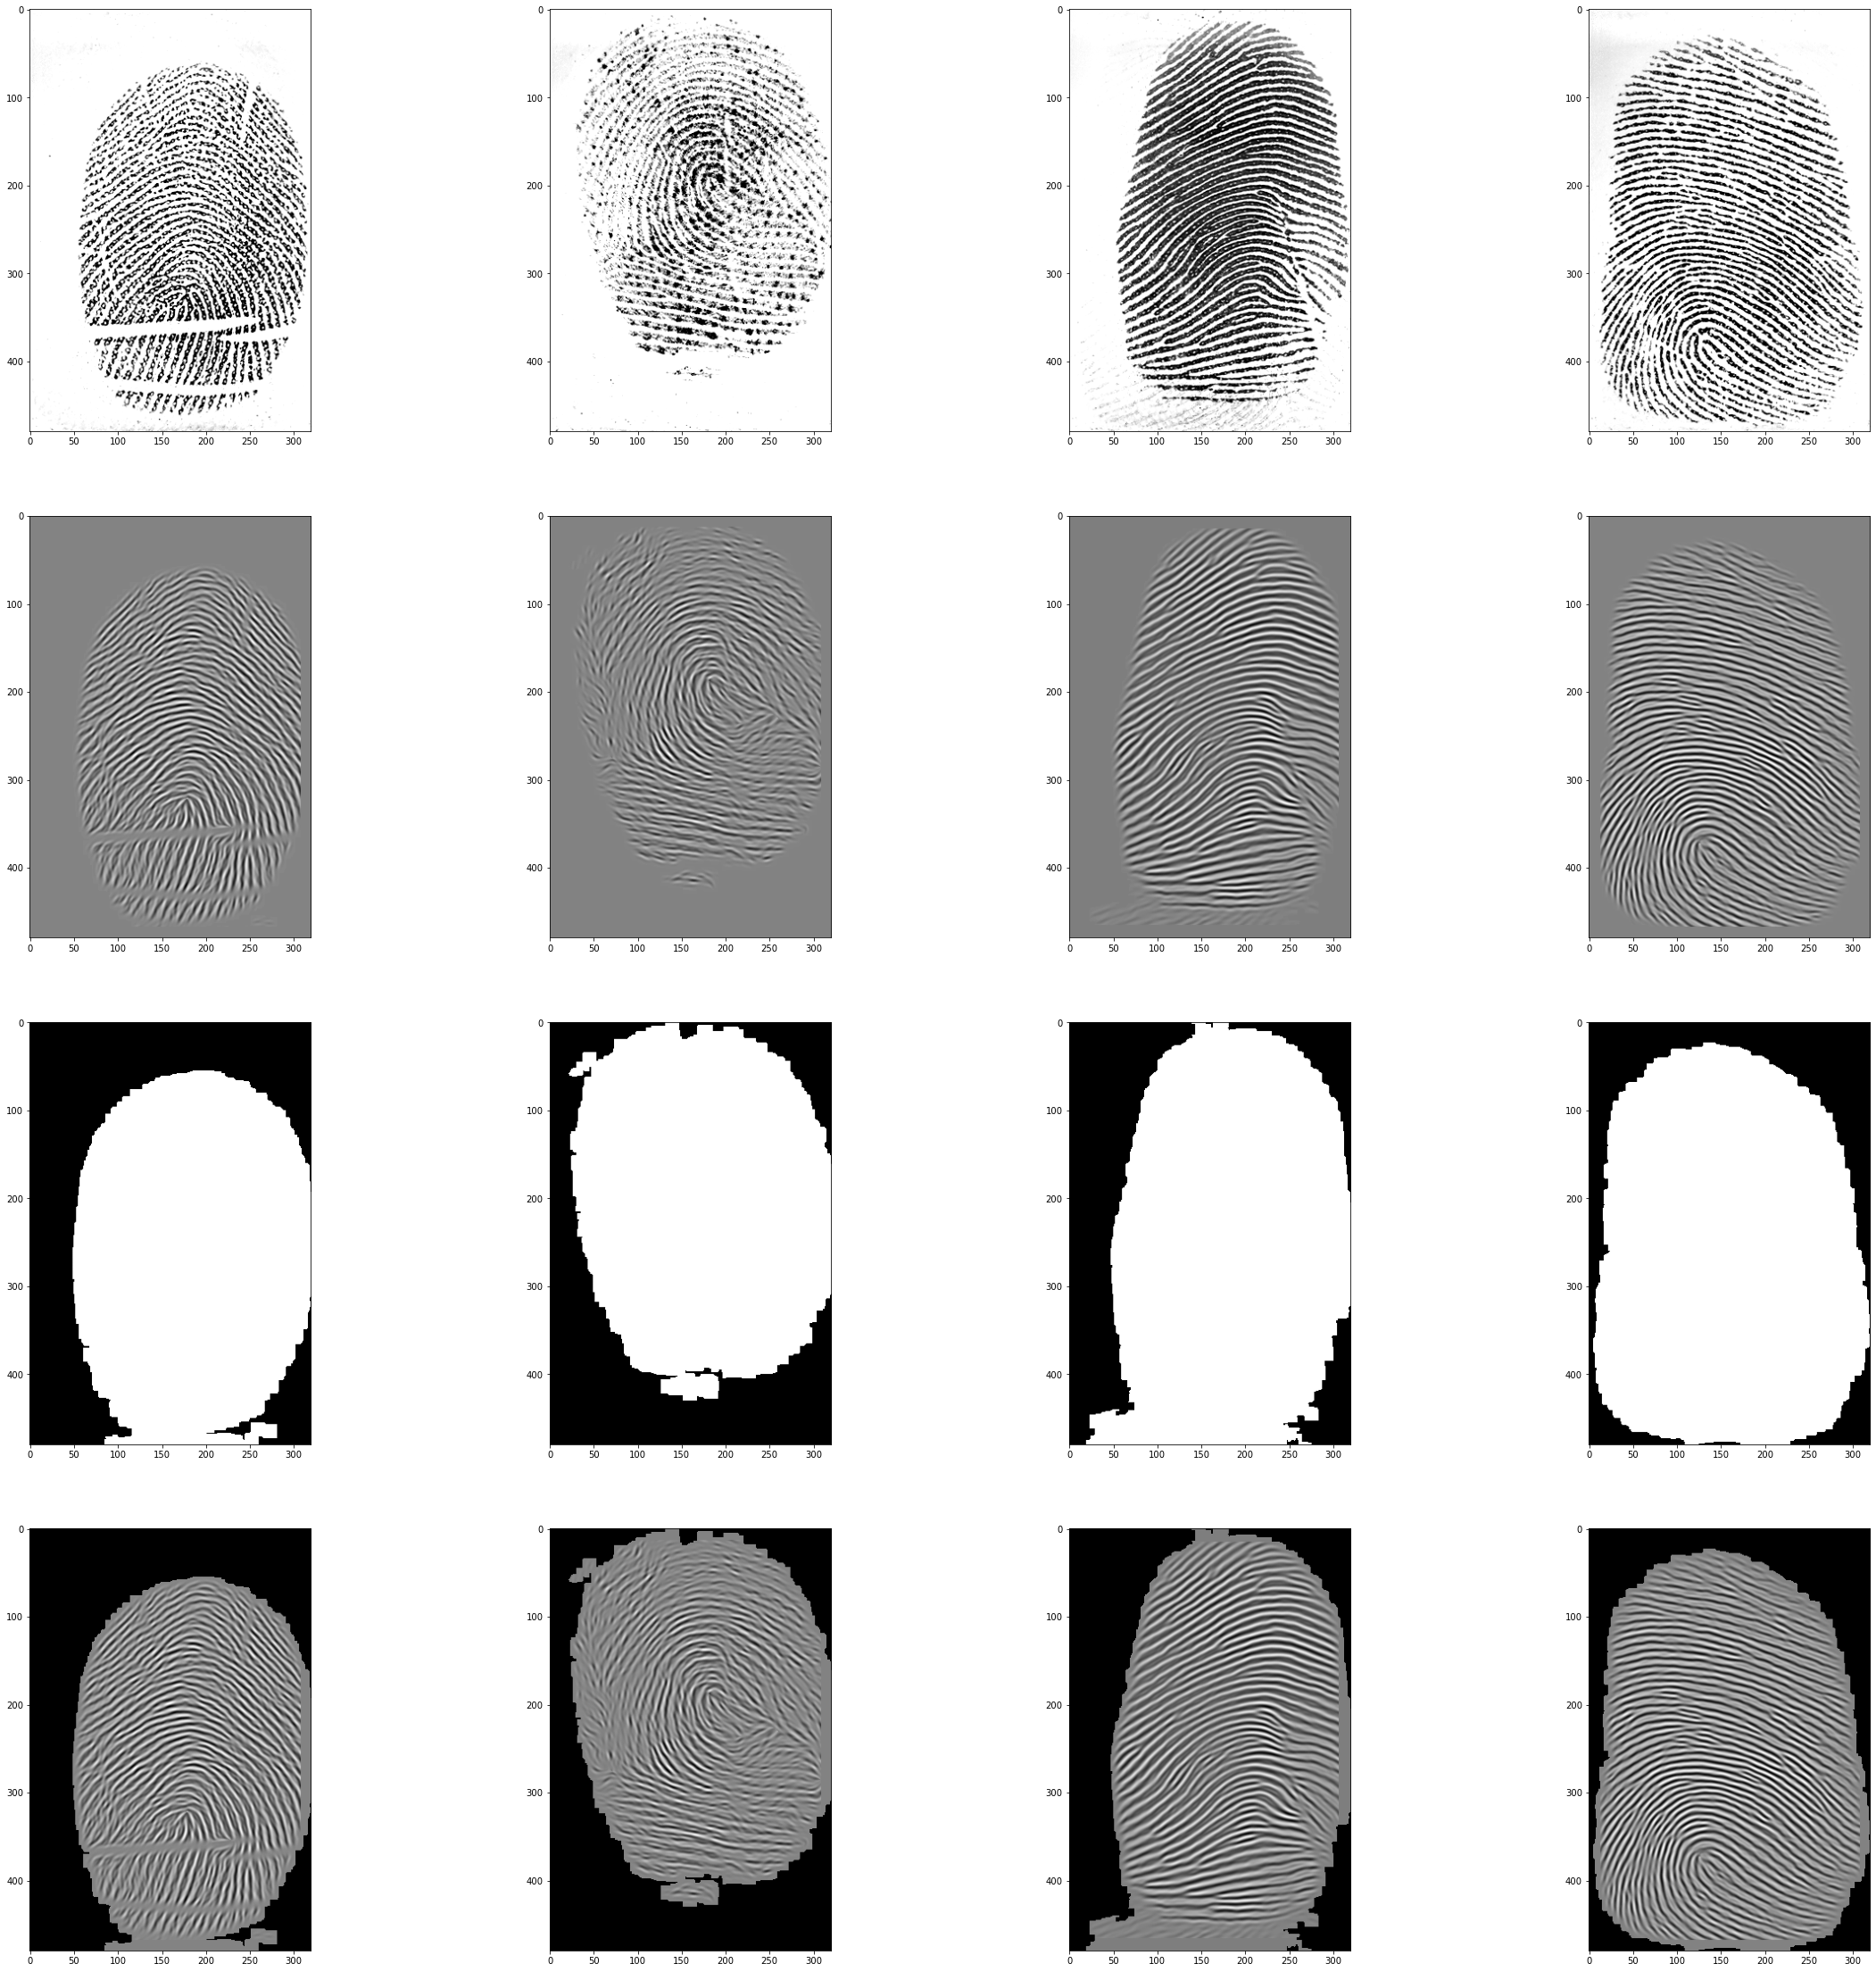

In [13]:
n=4
images_segmented_db = [a*b for a,b in zip(images_enhanced_db,masks_db)]
plot_image_sequence(images_db[:n] + images_enhanced_db.tolist()[:n] + masks_db.tolist()[:n] + images_segmented_db[:n], 4*n, n)

#### 3.2. Feature extraction
As you might have noticed by now comparing images on a pixel level is too simple and limited. The basic/traditional fingerprint matching algorithm are based on matching keypoints, called minutiae. They are defined as the ridge endings and bifurcations and can be determined by first thresholding the FP image and skeletonizing/thinning the enhanced image. For those really interested (but not part of this assignment) in experimenting with such an approach, some code is provided in the `fprmodules/minutiae_extraction` folder.

Instead, we will rely on establised methods developed in Computer Vision, where the use of keypoint features has proven to be very succesfull (prior to the advent of Deep Learning) in image classification, image alignment and object recognition tasks. A keypoint is a point of interest in an image, it does not necesarily need to be recognisable by a human but it can be. In this project we use keypoints to compare images on 3 levels:
1. Local feature descriptors
2. Global features
3. Hybrid features

To better highlight what is going on we will plot the results on two fingerprint images from our database.

In [14]:
# test example
testNr1 = 48

testNr2 = 17

**Keypoint detection** algorithms will result in points of interest on your image, which keypoints are used is dependent on the technique. We will make use of ORB (Oriented FAST and Rotated BRIEF) detection and descriptor algorithm as implemented in [OpenCV ORB](https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_orb/py_orb.html).


You are encouraged to try out a series of detection/description/matching algorithms. A short overview of these methods can be found in the OpenCV documentation: [Feature detection and description](https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_table_of_contents_feature2d/py_table_of_contents_feature2d.html). 
Please read these pages carefully and try to understand these methods.

In [15]:
def detect_keypoints(img, mask, keypoint_detector, kernel_size=(5,5)):
    """
        Detects keypoints in an image. 
        
        Note: Many false keypoints will be generated at the edge of the foreground mask, since ridges seem to terminate due to the clipping.
        we remove these by a morpholigical erosion (shrinking) of the foreground mask and deleting the keypoints outside.
    """
    # find the keypoints with ORB

    kp = keypoint_detector.detect(img)
    #convert mask to an unsigned byte
    mask_b = mask.astype(np.uint8)  
    # morphological erosion
    mask_e = cv2.erode(mask_b*255, kernel = np.ones(kernel_size,np.uint8), iterations = 5)
    # remove keypoints and their descriptors that lie outside this eroded mask
    kpn = [kp[i] for i in range(len(kp)) if mask_e.item(int(kp[i].pt[1]),int(kp[i].pt[0])) == 255] 
    return kpn

detector = cv2.ORB_create()
kp1 = detect_keypoints(images_enhanced_db[testNr1], masks_db[testNr1], detector)
kp2 = detect_keypoints(images_enhanced_db[testNr2], masks_db[testNr2], detector)

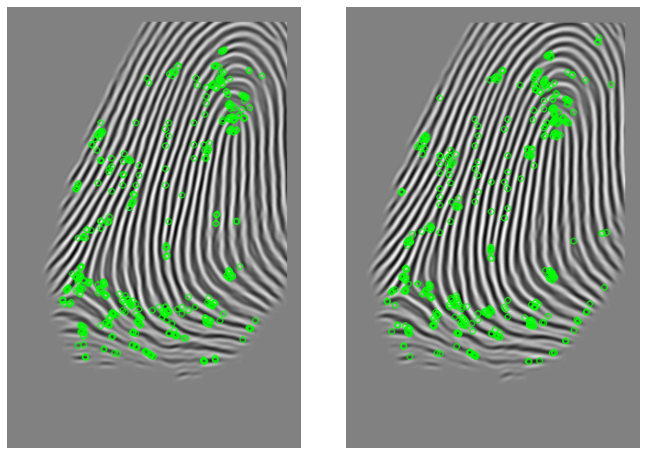

In [16]:
img1 = cv2.drawKeypoints(images_enhanced_db[testNr1],kp1,None,color=(0,255,0), flags=cv2.DRAW_MATCHES_FLAGS_DEFAULT)
img2 = cv2.drawKeypoints(images_enhanced_db[testNr2],kp2,None,color=(0,255,0), flags=cv2.DRAW_MATCHES_FLAGS_DEFAULT)

f, axarr = plt.subplots(1,2,sharey=True)
f.tight_layout()
#Uncomment below line to change figure size
f.set_size_inches(10,8)
axarr[0].axis('off')
axarr[1].axis('off')
axarr[0].imshow(img1),axarr[1].imshow(img2),plt.show();

**The Local Feature descriptor** will give you a vector describing the local region around the key-point in the feature space. Note that these feature descriptors give a vectorial summary of the neighbourhood around each keypoint. A simple metric on these vectors (Euclidean Distance for continuous variables, Hamming Distance for binary variables) can then be used to determine similarity.

In [17]:
def compute_local_descriptor(img, kp, detector):
    kp, des = detector.compute(img, kp)
    return np.array(kp), des

kp1, local_des1 = compute_local_descriptor(images_enhanced_db[testNr1], kp1, detector)
kp2, local_des2 = compute_local_descriptor(images_enhanced_db[testNr2], kp2, detector)

#### 3.3. Local Keypoint Matching
**Keypoint Matchers** match keypoints that have similar descriptors in an image pair and computes the distances between the best matching pairs of keypoints. In this implementation we make use of the brute force matcher of OpenCV, documentation can be found [here](https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_matcher/py_matcher.html). As a distance between descriptors we make use of the normalised [Hamming distance](https://en.wikipedia.org/wiki/Hamming_distance). 

In [18]:
def brute_force_matcher(des1, des2, dist=cv2.NORM_HAMMING):
    """
      Brute Force matcher on a pair of KeyPoint sets using the local descriptor for similarity
      
      returns all pairs of best matches
    """
    
    # crossCheck=True only retains pairs of keypoints that are each other best matching pair
    bf = cv2.BFMatcher(dist, crossCheck=True)
    matches = bf.match(des1, des2)
    
    # sort matches based on descriptor distance
    matches.sort(key=lambda x: x.distance, reverse=False)
    
    return np.array(matches)

# store the local keypoint matches
local_k1_k2_matches = brute_force_matcher(local_des1, local_des2, cv2.NORM_HAMMING)

# save the source index and target index of the keypoints in the corresponding keypoint sets
local_pt_source, local_pt_target = np.array([
    (match.queryIdx, match.trainIdx) for match in local_k1_k2_matches]).T

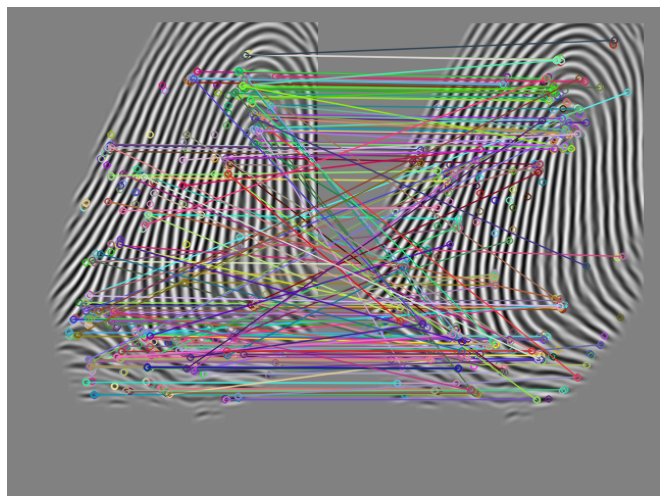

In [19]:
# Visualize the matched keypoints

imMatches = cv2.drawMatches(images_enhanced_db[testNr1],kp1,
                            images_enhanced_db[testNr2],kp2,local_k1_k2_matches, None) 
plt.imshow(imMatches)
plt.gcf().set_size_inches(18,9)
plt.gca().axis('off');

plt.show()

<div class="alert alert-block alert-success">
<b>Q2:</b> Are all the keypoint matches accurate? Are they expected to be? Explain why.
</div>

<div class="alert alert-block alert-info">
<b>Tip:</b> Make sure you spent the proper amount of time on constructing the similarity metrics, a good implementation will save you a lot of time in the long run! </div>

#### 3.4. Local Similarity metric
Now that we have matching keypoints we can define simple scalar measures on this set of distances, such as the number of pairs with a distance smaller than a set threshold, or the sum/mean of the first N distances (ranked from small to larger), etc.

In [20]:
def local_img_similarity(matches):
    # feature distance
        
    # given these matches we have to come up with a metric, note that some of the matches will be successful 
    # while others will be faulty, it is important that we only take reliable matches as to not skew the similarity
    dist = [i.distance for i in matches]
    dist.sort()
    top_n = 30
    best_n_matches = dist[:top_n]    
    scores =1/(np.mean(best_n_matches)+np.finfo(float).eps)
    return scores

In [21]:
def local_similarity(masked_fp1, masked_fp2, detector=cv2.ORB_create(), kp_erosion_ksize = (5,5)):
    # separate the semgentation from the image
    fp1, mask1 = masked_fp1[...,0], masked_fp1[...,1] 
    fp2, mask2 = masked_fp2[...,0], masked_fp2[...,1] 
    
    # detect the keypoints
    kp1 = detect_keypoints(fp1, mask1, detector, kernel_size = kp_erosion_ksize)
    kp2 = detect_keypoints(fp2, mask2, detector, kernel_size = kp_erosion_ksize)
    
    # compute descriptor for each keypoints
    kp1, local_des1 = compute_local_descriptor(fp1, kp1, detector)
    kp2, local_des2 = compute_local_descriptor(fp2, kp2, detector)
    
    # find matches between keypoints based on local feature descriptor
    local_k1_k2_matches = brute_force_matcher(local_des1, local_des2, cv2.NORM_HAMMING)
    
    # distances between matches that are below threshold
    return local_img_similarity(local_k1_k2_matches)
    


<div class="alert alert-block alert-info">
<b>Tip:</b> Don't forget to apply the same preprocessing to the perpetrator image.

</div>


In [22]:
perp_img_en, perp_img_mask = enhance_images([perpetrator_fp])
perp_img_en = perp_img_en[0]
perp_img_mask = perp_img_mask[0]

  0%|          | 0/1 [00:00<?, ?it/s]

#### 3.5 Local Similarity Scores

In [23]:
sim_tb1 = constructSimilarityTable(np.stack((perp_img_en,perp_img_mask),-1), np.stack((images_segmented_db,masks_db),-1), labels_db, local_similarity)

1 056 0.03722
2 049 0.03597
3 048 0.03297
4 018 0.03254
5 076 0.03229
6 022 0.03064
7 053 0.01946
8 068 0.01902
9 045 0.01869
10 097 0.01853


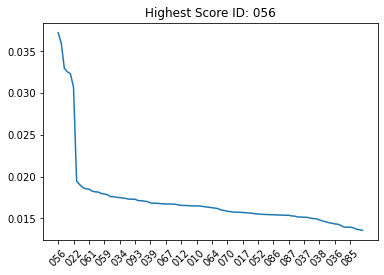

In [24]:
sim_tb1 = sim_tb1.sort_values(by='score', ascending=False)
ids,scores = sim_tb1.values[:,0],sim_tb1.values[:,1]
plt.plot(ids,scores)
plt.xticks(np.arange(0,100,5),ids[np.arange(0,100,5)],rotation = 45)
plt.title('Highest Score ID: '+ids[0]);

[print(i+1, sim_tb1.iloc[i,0], f"{sim_tb1.iloc[i,1]:.5f}") for i in range(10)];


A good idea in this plot, where we cannot see one clear subject (as the first 6 subjects are all pretty close), is to take a look at the knee point for a score threshold. Also, let's normalize our scores in order to get a well generalized scale.

Knee at: 8	 Treshold:  0.21680204552806615


 With the threshold of 0.217, we can see a more clear divide between the subjects. However, the best 6 matches are all pretty close... We should be able to come up with a better discriminator by using a global similarity metric.

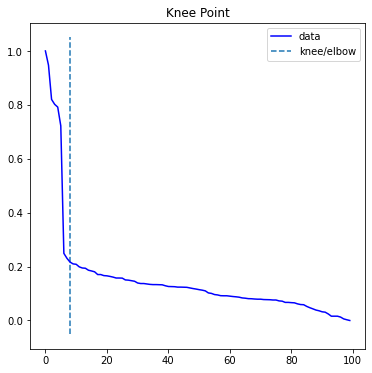

In [25]:
#Simple module to find the knee in a series
from kneed import KneeLocator

scores_local = (scores - scores.min()) / (scores.max() - scores.min())

kneedle = KneeLocator(list(range(len(ids))),scores_local,S=1, curve='convex', direction='decreasing')
print(f'Knee at: {kneedle.knee}\t Treshold: ',kneedle.knee_y)
kneedle.plot_knee()
Markdown(f" With the threshold of {kneedle.knee_y:.3f}, we can see a more clear divide between the subjects. However, the best 6 matches are all pretty close... We should be able to come up with a better discriminator by using a global similarity metric." )

### 4. Model extension 2: Global similarity


**Global features**, here we use the matching keypoints to align the fingerprints, this allows us to compare the images as a whole (globally). Once the images are aligned we can take into account the distance between the key-points in the ambient space (the coordinates of the key-points). This is also referred to as geometrical distance since this is just comparing two points that are part of the intrinsic geometry of the object (no matter how you move the image around the point will move around with it and stay in the same location on the finger).

#### 4.1 Image alignment
[Here](https://www.learnopencv.com/image-alignment-feature-based-using-opencv-c-python/) you can find a description and code how to start from the brute force matching results and estimate the best transformation (from a family of transformations) that aligns the two images. In the example, a homography-type transformation is searched for. However, this has too many degrees of freedom for our application. We substituted this by a more constrained (only 4 degrees of freedom) similarity (partial affine) transformation.

These routines iteratively determine the minimal set of matching points that define a transformation that optimally aligns all other points as well, taking care of outliers at the same time. This method is a very general optimization technique and is called RANSAC, for "RANdom SAmple Consensus". See, apart from many other sources on the internet, [this presentation](http://www.cse.psu.edu/~rtc12/CSE486/lecture15.pdf) for further explanation. 

In [27]:
def estimate_affine_transform_by_kps(src_pts, dst_pts):
    """
        Returns the Affine transformation that aligns two sets of points
    """
    transform_matrix, inliers = cv2.estimateAffinePartial2D(src_pts, dst_pts, 
                                           method =  cv2.RANSAC, 
                                           confidence = 0.9, 
                                           ransacReprojThreshold = 10.0, 
                                           maxIters = 5000, 
                                           refineIters = 10)
    return transform_matrix, inliers[:,0]

def warp_points(pts, M):
    mat_reg_points = cv2.transform(pts.reshape(-1,1,2), M)
    
    # return transformed keypoint list
    return cv2.KeyPoint.convert(mat_reg_points) 

def warp_img(img, M):
    return cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))

# estimate the affine transform that aligns the matched keypoints
M, inliers = estimate_affine_transform_by_kps(
    cv2.KeyPoint.convert(np.array(kp1)[local_pt_source]), 
    cv2.KeyPoint.convert(np.array(kp2)[local_pt_target]))

kp1_reg = warp_points(cv2.KeyPoint.convert(kp1), M)
img1_reg =  warp_img(images_enhanced_db[testNr1], M)

Let's have a look at how the images are alinged. Try visualizing different pairs of fingerprints! You may notice the estimated transform will be more extreme for images that are less similar, and will become more subtle as the images become more similar.

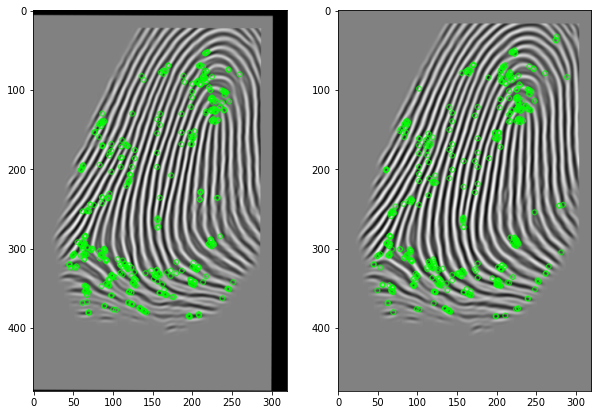

In [28]:
show_img1 = cv2.drawKeypoints(img1_reg, kp1_reg, None, (0, 255, 0), cv2.DRAW_MATCHES_FLAGS_DEFAULT)
show_img2 = cv2.drawKeypoints(images_enhanced_db[testNr2], kp2, None, (0, 255, 0), cv2.DRAW_MATCHES_FLAGS_DEFAULT)

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(10,10))
_=ax[0].imshow(show_img1), ax[1].imshow(show_img2), plt.show()

As you might have noticed the `estimateAffinePartial2D` function does not only return the transformation matrix but also the minimal set of matching points that were used to to determine the transformation. This gives us a better, more refined set of keypoints. 

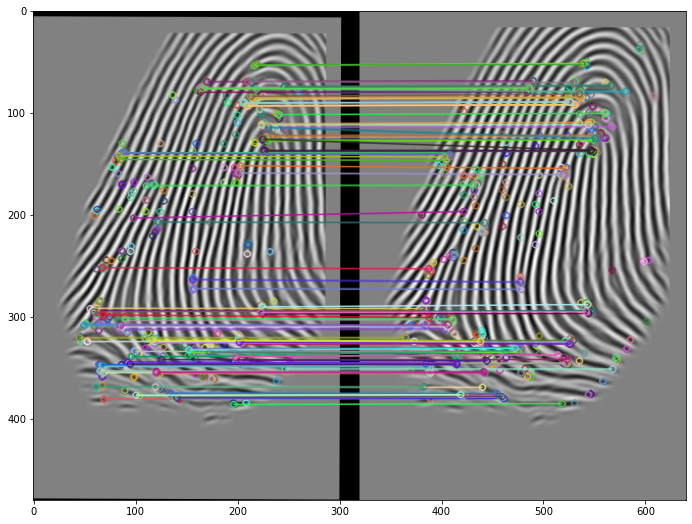

In [29]:
global_k1_k2_matches = local_k1_k2_matches[inliers == 1]

imMatches = cv2.drawMatches(img1_reg, kp1_reg, images_enhanced_db[testNr2], kp2, global_k1_k2_matches.tolist(), None)
_ = plt.imshow(imMatches)
f=plt.gcf()
f.set_size_inches(18,9), plt.show();

#### 4.2 Global Similarity Metric

<div class="alert alert-block alert-success">
<b>Q3: </b> Choose a global feature similarity function, (e.g. you can start from euclidean distance between the reduced sets of KeyPoints and count the values above a threshold).
</div>

In [ ]:
def get_reduced_set(matches,reg_kp1,kp2):
    # get reduced keypoint set from matches
    reg_kp1 = cv2.KeyPoint_convert(reg_kp1)
    kp2 = cv2.KeyPoint_convert(kp2)
    kp1_reduced,kp2_reduced = [],[]
    for i in matches:
        kp1_reduced.append(reg_kp1[i.queryIdx])
        kp2_reduced.append(kp2[i.trainIdx])
    return kp1_reduced,kp2_reduced

In [30]:
def global_img_similarity(matches, reg_kp1, kp2):
    return None

In [31]:
def global_similarity(masked_fp1, masked_fp2, detector=cv2.ORB_create(), kp_erosion_ksize = (5,5)):
    # separate the semgentation from the image
    fp1, mask1 = masked_fp1[...,0], masked_fp1[...,1] 
    fp2, mask2 = masked_fp2[...,0], masked_fp2[...,1] 
    
    # detect the keypoints
    kp1 = detect_keypoints(fp1, mask1, detector, kernel_size = kp_erosion_ksize)
    kp2 = detect_keypoints(fp2, mask2, detector, kernel_size = kp_erosion_ksize)
    
    # compute descriptor for each keypoints
    kp1, local_des1 = compute_local_descriptor(fp1, kp1, detector)
    kp2, local_des2 = compute_local_descriptor(fp2, kp2, detector)
    
    # find matches between keypoints based on local feature descriptor
    local_k1_k2_matches = brute_force_matcher(local_des1, local_des2, cv2.NORM_HAMMING)
    
    # get source and target index for each match
    local_pt_source, local_pt_target = np.array([
        (match.queryIdx, match.trainIdx) for match in local_k1_k2_matches]).T
    
    # use matching keypoints to estimate an affine transform between keypoints
    M, inliers = estimate_affine_transform_by_kps(
        cv2.KeyPoint.convert(kp1[local_pt_source]), 
        cv2.KeyPoint.convert(kp2[local_pt_target]))
    
    # if no inliers can be found
    if M is None: 
        return 0
    
    # warp the keypoints according to the found transform
    kp1_reg = warp_points(cv2.KeyPoint.convert(kp1), M)
    
    # subset the keypoints, inliers are considered good keypoints
    # since they were used in finding the transformation
    global_k1_k2_matches = local_k1_k2_matches[inliers == 1]
    
    # compute global similarity based aligned matching global keypoints
    return global_img_similarity(global_k1_k2_matches,kp1_reg, kp2)
 

sim_tb2 = constructSimilarityTable(np.stack((perp_img_en,perp_img_mask),-1), np.stack((images_segmented_db,masks_db),-1), labels_db, global_similarity)

<div class="alert alert-block alert-success">
<b>Q4: </b> Visualize the scores and determine a score threshold to discriminate the matching fingerprints. Explain how you determine the threshold.
</div>

### 5. Model extension 3: Hybrid features


Since we again run into the same problem of a lack of clear disctinction, we can now give hybrid features a shot.

#### 5.1 Hybrid Similarity metric
<div class="alert alert-block alert-success">
<b>Q5: </b> Choose a hybrid feature similarity function that makes use of both the geometric distance and the feature distance of the keypoints. Using this hybrid function, visualize and assess the matches.
</div>

In [34]:
def hybrid_img_similarity(matches, kp1_reg, kp2):
    return None

#### 5.2 Construct hybrid similarity matrix


In [35]:
def hybrid_similarity(masked_fp1, masked_fp2, detector=cv2.ORB_create(), kp_erosion_ksize = (5,5)):
    # separate the semgentation from the image
    fp1, mask1 = masked_fp1[...,0], masked_fp1[...,1] 
    fp2, mask2 = masked_fp2[...,0], masked_fp2[...,1] 
    
    # detect the keypoints
    kp1 = detect_keypoints(fp1, mask1, detector, kernel_size=kp_erosion_ksize)
    kp2 = detect_keypoints(fp2, mask2, detector, kernel_size= kp_erosion_ksize)
    
    # compute descriptor for each keypoints
    kp1, local_des1 = compute_local_descriptor(fp1, kp1, detector)
    kp2, local_des2 = compute_local_descriptor(fp2, kp2, detector)
    
    # find matches between keypoints based on local feature descriptor
    local_k1_k2_matches = brute_force_matcher(local_des1, local_des2, cv2.NORM_HAMMING)
    
    # get source and target index for each match
    local_pt_source, local_pt_target = np.array([
        (match.queryIdx, match.trainIdx) for match in local_k1_k2_matches]).T
    
    # use matching keypoints to estimate an affine transform between keypoints
    M, inliers = estimate_affine_transform_by_kps(
        cv2.KeyPoint.convert(kp1[local_pt_source]), 
        cv2.KeyPoint.convert(kp2[local_pt_target]))
    
    # if no inliers can be found
    if M is None: 
        return 0
    
    # warp the keypoints according to the found transform
    kp1_reg = warp_points(cv2.KeyPoint.convert(kp1), M)
    
    # subset the keypoints, inliers are considered good keypoints
    # since they were used in finding the transformation
    global_k1_k2_matches = local_k1_k2_matches[inliers == 1]

     # compute hybrid similarity based on aligned matching keypoints
    return hybrid_img_similarity(global_k1_k2_matches, kp1_reg, kp2)
    
sim_tb3 = constructSimilarityTable(np.stack((perp_img_en,perp_img_mask),-1), np.stack((images_segmented_db,masks_db),-1), labels_db, hybrid_similarity)

Oh no! Still no clear distinction... This is suspicious, let's take a look at the best matching fingerprints.

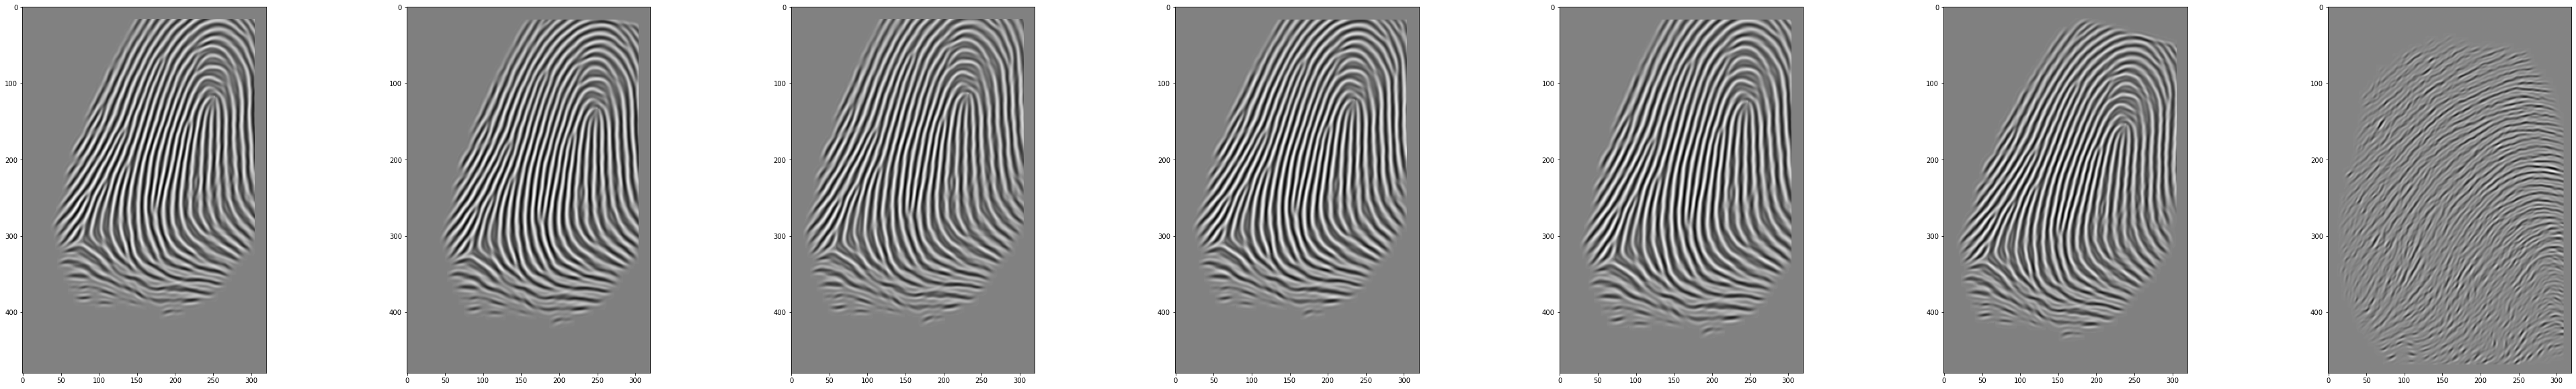

In [39]:
def get_image_by_label(ind):
    for i in range(len(labels_db)):
        if labels_db[i] == ind:
            return images_enhanced_db[i]
    raise ValueError("No image with this label is found.")

imgs = [get_image_by_label(i) for i in ids[:kneedle.knee]]

plot_image_sequence(imgs,kneedle.knee if kneedle.knee<=7 else 7)

The top matching subjects all have the same fingerprint! The murderer must have hacked the database and replicated some of the images, effectively covering their tracks. They seem to be one step ahead all the time... Or so they think! Fingerprints are not the only biometric you can evaluate.

You call your friends at CSI New York and send them the video surveillance records. By making use of the revolutionary (and non-existent) technology of ***zoom-and-enhance***, they return to you a database of iris images.

![Zoom and Enhance](img/csi_zoom_enhance.gif)

## III. Iris recognition
Now let's create a biometric system for the iris data. 

In [11]:
# set path
# CHANGE THIS FOR YOUR SYSTEM
iris_data_path = 'C:/Users/OneDrive - KU Leuven/assignment2_2022/data/CASIA1'

### 1. Reading data

<div class="alert alert-block alert-success">
<b>Q6: </b> Check out <code>iris_perpetrator.png</code>. Where do you see difficulties? What kind of similarity measures do you expect to work best?
</div>

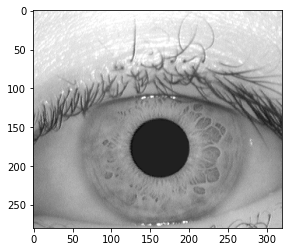

In [8]:
iris_perpetrator = cv2.cvtColor(cv2.imread("perpetrator_iris.bmp"),cv2.COLOR_BGR2GRAY)
plt.imshow(iris_perpetrator,cmap='gray');

Let's read the iris data... The images are stored as XXX.png, where XXX stands for the unique identifier of subject, ranging from from 000 to 100.

In [12]:
def read_iris_DB(path):
    images = []
    labels = []
    imagePaths = sorted(os.listdir('data/CASIA1'))

    for imagePath in imagePaths:
        if imagePath.endswith('.png'):
            label = imagePath.split('.')[0]
            image = cv2.imread(path +'\\' + imagePath)

            if (len(image.shape) > 2):
                image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            images.append(image)
            labels.append(label)

    return np.array(images), np.array(labels)

# read iris Database
iris_images, iris_labels = read_iris_DB(iris_data_path)

# save data properties
n_images = len(iris_images)
img_height, img_width = iris_images[0].shape[0], iris_images[0].shape[1]

Markdown("""
Let's have a look at the dataset... It contains {} images of size of the images is {}×{}. Let's visualise the first 7:
""".format(n_images,img_height,img_width))


Let's have a look at the dataset... It contains 100 images of size of the images is 280×320. Let's visualise the first 7:


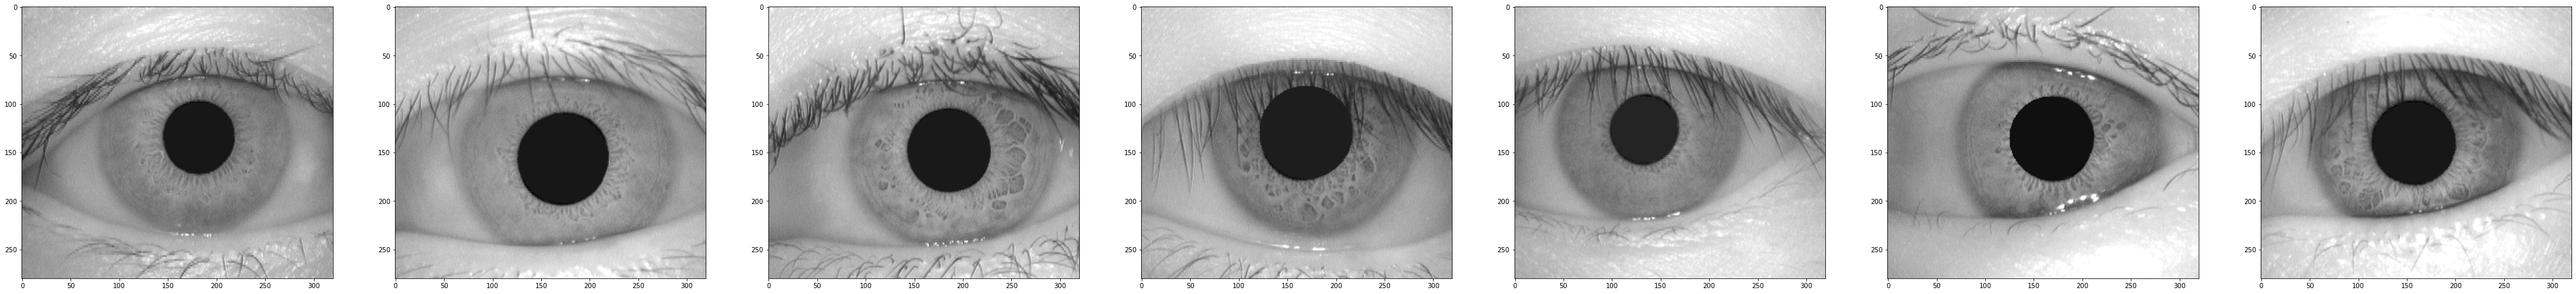

In [43]:
n = 7
plot_image_sequence(iris_images, n)

### 2. Biometric iris recogntion System
#### 2.1. Image enhancement
Similar to the image enhancement in the [fingerprints](#3.1.-Image-enhancements) section, we will use [open source code](https://github.com/thuyngch/Iris-Recognition) to segment (based on Daugman's intefro-differential) and normalise (by unwraping the circular region) the iris images. We strongly encourage you to go through the source code or github repository to learn more. 

Also similar to the fingerprint section we enhance the images using a gabor filter bank, this time we implement this using [OpenCV](https://docs.opencv.org/3.4/d4/d86/group__imgproc__filter.html#gae84c92d248183bd92fa713ce51cc3599). 

In [44]:
import warnings
warnings.filterwarnings('ignore')

from src.irismodules.iris_recognition.python.fnc import segment, normalize

# we use the same hyper parameters as in the enroll-casia1.py example
# feel free to play around with these!
eyelashes_thres = 150
radial_res = 200
angular_res = 500

def segment_iris(img):
    # Segment the iris region from the eye image. Indicate the noise region.
    ciriris, cirpupil, imwithnoise = segment.segment(img)

    # Normalize iris region by unwraping the circular region into a rectangular block of constant dimensions.
    polar_iris, mask = normalize.normalize(
        imwithnoise, ciriris[1], ciriris[0], ciriris[2], cirpupil[1], cirpupil[0], cirpupil[2], radial_res, angular_res)
    
    return polar_iris, (mask == 0)      

def get_filter_bank(ksize = 5,sigma = 4, theta_range = np.arange(0,np.pi,np.pi/16), lambd=10,gamma = 0.5,psi=0 ):
    # this filterbank comes from https://cvtuts.wordpress.com/
    filters = []
    for theta in theta_range:
        kern = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma, psi, ktype=cv2.CV_32F)
        kern /= 1.5*kern.sum()
        filters.append(kern)
    return filters
    cv2.getGaborKernel()
def enhance_iris(img, eps = 1.e-15, agg_f = np.max):
    # get the gabor filters
    filters = get_filter_bank()

    # apply filters to image
    enhanced_image = np.array([cv2.filter2D(img, ddepth = -1, kernel=k) for k in filters])
    
    # Normalize in the [0,255] range
    enhanced_image = cv2.normalize(enhanced_image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=0)
    
    # aggregate features
    return agg_f(enhanced_image,0)
    
def enhance_and_segment_irises(images):
    enhanced_images, masks = [], []
    for img in tqdm_notebook(images):
        normalised_img, mask = segment_iris(img)
        enhanced_img = enhance_iris(normalised_img)
        
        masks.append(mask)
        enhanced_images.append(enhanced_img)
    
    return np.array(enhanced_images), np.array(masks)

try:
    with open("iris_mask_db.pkl","rb") as f:
        enhanced_iris,mask_iris = pickle.load(f)
except:
    enhanced_iris, mask_iris = enhance_and_segment_irises(iris_images)
    with open("iris_mask_db.pkl","wb") as f:
        pickle.dump([enhanced_iris,mask_iris],f)
    

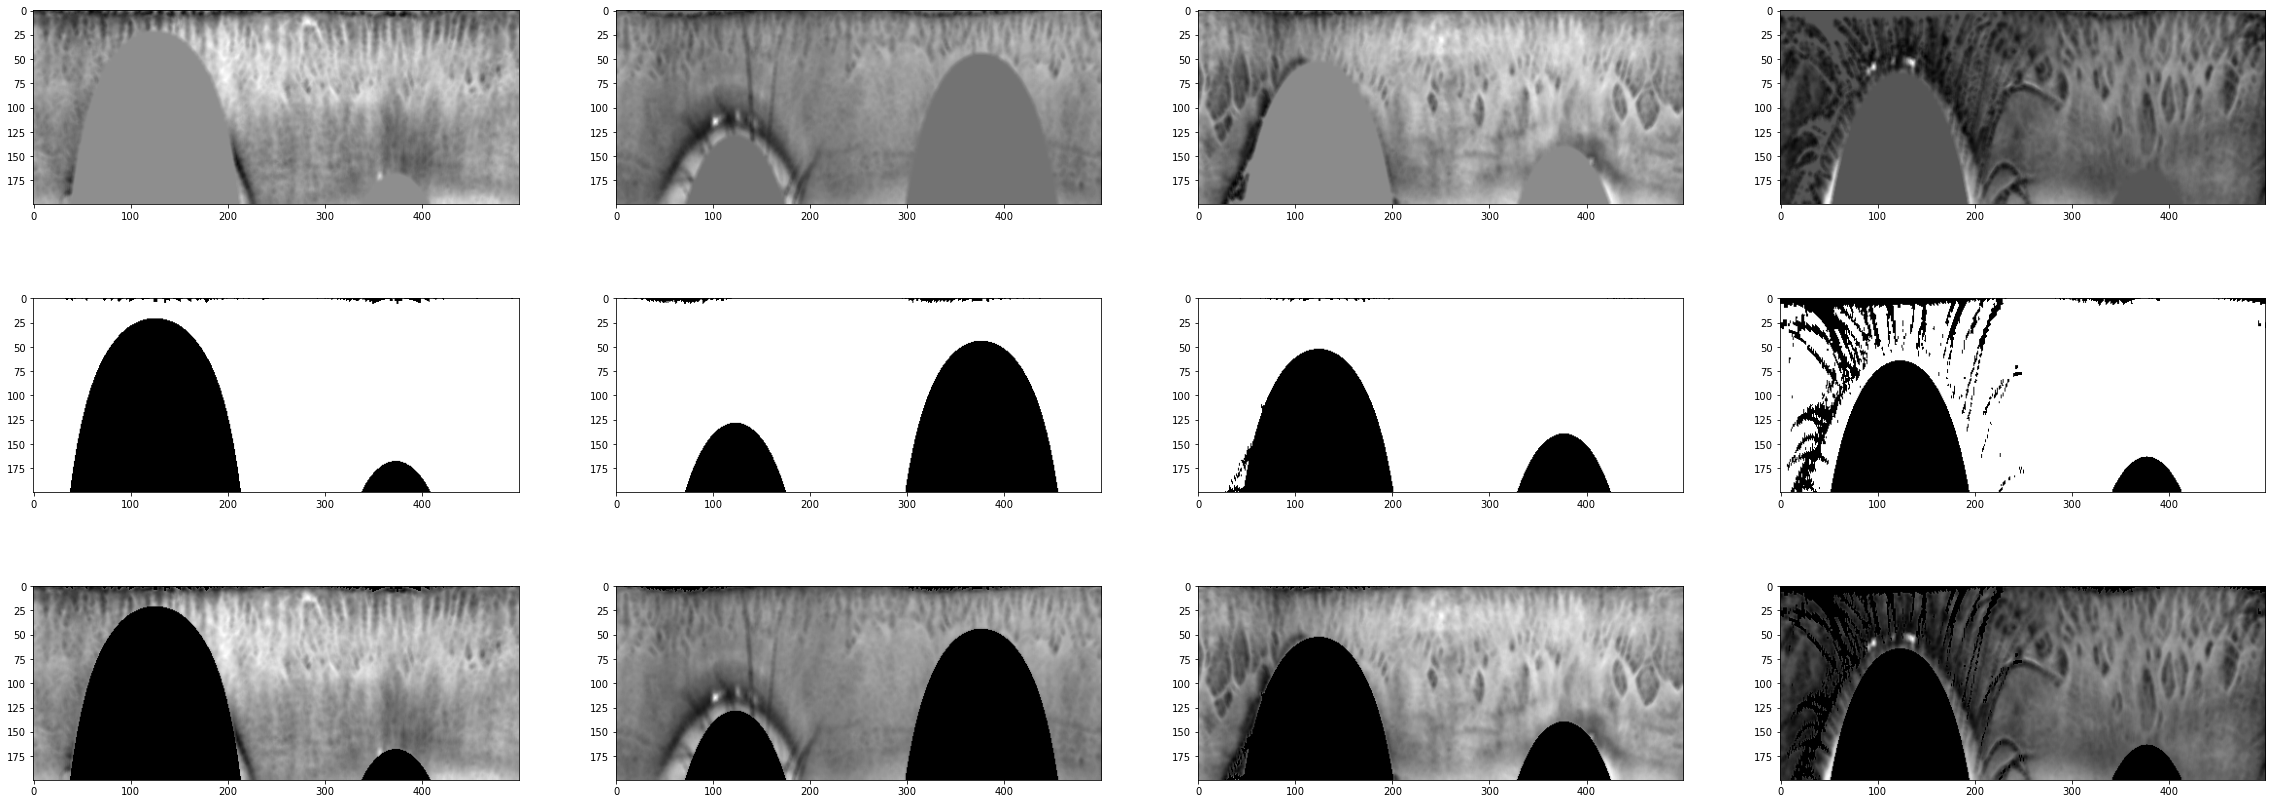

In [45]:
n=4


iris_segmented_db = np.array([a*b for a,b in zip(enhanced_iris, mask_iris)])
plot_image_sequence(enhanced_iris.tolist()[:n] + mask_iris.tolist()[:n] + iris_segmented_db.tolist()[:n], 3*n, n, figsize= (10,5), cmap='gray')

<div class="alert alert-block alert-success">
<b>Q7: </b> Construct a similarity table with the iris images. Use local OR global matches in order to get scores. Use the scores you get to determine the perpetrator.
</div>

How is this possible? Iris scans don't provide a clear suspect either. 

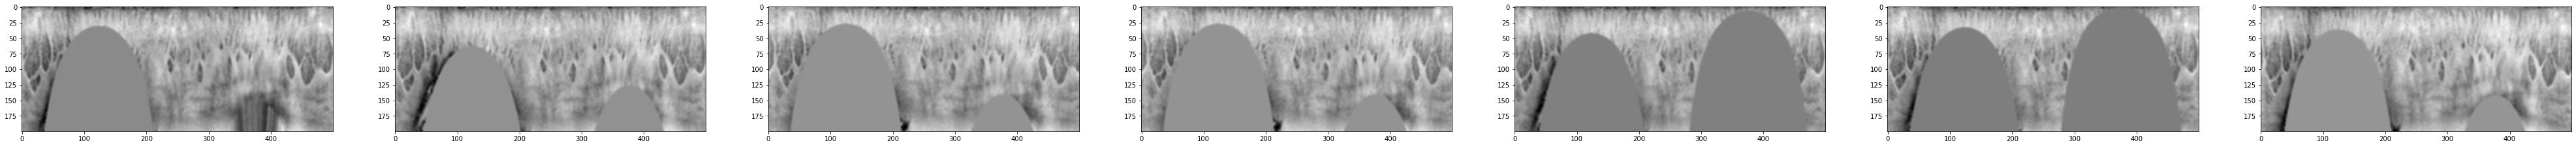

In [51]:
def get_iris_image_by_label(ind):
    for i in range(len(iris_labels)):
        if iris_labels[i] == ind:
            return enhanced_iris[i]
    raise ValueError("No image with this label is found.")

imgs = [get_iris_image_by_label(i) for i in ids[:kneedle.knee]]

plot_image_sequence(imgs,kneedle.knee if kneedle.knee<=7 else 7)

They are all the same once again. There is no doubt about it now, there is an insider messing with the data! Lucky for us, but unlucky for them, they slipped up. We can now construct a multimodal biometric system in order to catch the perpetrator.

## IV Multimodal System

<div class="alert alert-block alert-success">
<b>Q8: </b> Fuse your iris and fingerprint biometric system on the score level to solve the murder case! Do you feel confident in your prediction? How do you fuse the scores? Why?
</div>

## V. Assignment Instructions
Both a report and the implementation in this notebook have to be submitted to toledo. <u>The notebook functions as supplementary material only!</u> The report should be self contained. Feel free to add figures, code and mathematics in the report if you feel comfortable. Try to be concice and to the point and try keep your report below 10 pages. 

1. Follow the instructions in the notebook and discuss results/impact in your report.
2. <b>Choose a number of tasks equivalent to <u>at least 6pts</u> from the list below (pts are not related to the grades): </b>
    1. [FING and IRIS] OpenCV provides different KeyPoint detectors and descriptors (ORB, SIFT, SURF, BRIEF, ...). Briefly test, visually, which of these seem to extract relatively reliable interesting points from the fingerprints or iris dataset (you can skip the ones that require a lisence). Use <u> at least 3 detectors</u>. (1pt)
    2. [IRIS] Play around with the gabor filter bank, what is the effect of the parameters? Can you setup a databank that results in better features? (1pt)
    3. [FING] Can you find a better way to aggregate the gabor feature maps? Analyse and report. (1pt) 
    4. [IRIS] Compare local hybrid and global features for the iris data (1pt).
    5. [FING] Try a neural network approach in order to get similarity scores directly from image data without feature extraction. (1pt)
    6. [FING] Attempt to improve the registration procedure. (1pt) 
    7. [FING or IRIS] Attempt to improve the segmentation, evaluate. (3pt) 
    8. [FING or IRIS] Attempt to improve the feature extraction using a completely different technique. Evaluate your results. (3pt)
    9. [MULTI] Fuse your modalities on the feature level instead of the score level (3pt)
    10. [ . ] Create a biometric identification or authentication system on a modality of choice and evaluate it (6pt)
        - e.g. on smartphone usage patterns 
        - Excludes; Fingerprints, irises and faces
    11. [FING or IRIS] Create a machine learning based identification/authentication system and evaluate it (6pt)
        - e.g. based on deep learning 
        - training is required, transfer learning is allowed 
3. All results should be discussed in detail in your report. 


<em>Note: Indicate clearly which tasks you end up choosing and where we can find the implementations and/or results. </em> <br>
<em>Note 2: Usually there are multiple valid solutions, you should always defend your approach and verbally compare it to the other approaches (possible advantages/disadvantages) in your report! If you do not provide proper reasoning we can not give you the grades you deserve! </em>

Good luck, have fun!